In [1]:
from __future__ import print_function, division
%run ../basics.ipynb

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['show_config']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Loading BokehJS ...

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/learning_resources.csv')
display(df.head(2))
tags = pd.read_csv('../data/tags.csv')

display(tags.head(2))
df['tags'] = df['id'].apply(lambda x: (' '.join(tags[tags['id'] == x]['concept_tag'].values.tolist())).strip())

edx_idx = df['venue'] == 'edX'
tags = pd.read_csv('../data/edX Tag Assignment - FG validation%2Fassignments.csv')
df['tags'].loc[edx_idx] = df['id'].loc[edx_idx].apply(lambda x: (' '.join(tags[tags['id'] == x]['tag'].values.tolist())).strip())
print(df.columns)
print(df.count()/len(df)*100)
df.head(2)

,id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,created,...,available,end_date,typical_learning_time,rating,price,new,language,format,license,venue
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,NaN,...,NaN,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,NaN,...,NaN,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity


,id,shortname,concept_tag,url
0,ud257,ab-testing--ud257,video_lecture,https://www.udacity.com/course/ab-testing--ud2...
1,ud257,ab-testing--ud257,in_depth,https://www.udacity.com/course/ab-testing--ud2...


Index([u'id', u'title', u'subtitle', u'description', u'short_description',
       u'syllabus', u'url', u'slug', u'difficulty', u'created',
       u'date_modified', u'date_published', u'available', u'end_date',
       u'typical_learning_time', u'rating', u'price', u'new', u'language',
       u'format', u'license', u'venue', u'tags'],
      dtype='object')
id                       100.000000
title                     99.781659
subtitle                  25.545852
description               85.152838
short_description          3.711790
syllabus                  10.043668
url                      100.000000
slug                     100.000000
difficulty                24.235808
created                   44.978166
date_modified              0.000000
date_published            44.978166
available                 44.978166
end_date                   0.000000
typical_learning_time     44.104803
rating                    17.685590
price                     98.689956
new                        0.00

,id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,created,...,end_date,typical_learning_time,rating,price,new,language,format,license,venue,tags
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,NaN,...,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity,video_lecture project overview computer_scienc...
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,NaN,...,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity,video_lecture in_depth project data_collection...


In [20]:
class CLF(object):
    def __init__(self, n_topics=20, tfidf_max_df=None, tfidf_min_df=None, tag_vec_max_df=None, tag_vec_min_df=None, 
                 ngram_range=None, nmf=True, **kwargs):
        self.n_topics = n_topics
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                          max_df=0.6 if tfidf_max_df is None else tfidf_max_df,
                                          min_df=5 if tfidf_min_df is None else tfidf_min_df,
                                          ngram_range=(1 ,3) if ngram_range is None else ngram_range)
        
        self.tag_vectorizer = CountVectorizer(max_df=.3 if tag_vec_max_df is None else tag_vec_max_df,
                                              min_df=0 if tag_vec_min_df is None else tag_vec_min_df)
        
        self.nmf = NMF(n_components=n_topics, random_state=2016) if nmf else None
        self.rf = None
        self.knn = None
        self.topic_dict = None
        self.kwargs = kwargs

    def fit(self, X, y, viz=True):
        orig_X = X.copy()
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=True, viz=viz)
        if viz:
            try:
                tsne_plot(X, orig_X[[orig_X.columns[0]]], fit=True)
            except:
                print(traceback.format_exc())
        y = self.vectorize_y(y, fit=True)
        #from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble  import RandomForestClassifier
        #from sklearn.ensemble import AdaBoostClassifier
        self.rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=8, class_weight='balanced', n_jobs=-1))
        self.knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=1))
        # self.clf = OneVsRestClassifier(LogisticRegression())
        filt = np.array(y.sum(axis=1) > 0).flatten() # don't train on untagged resources
        if sum(filt) != y.shape[0]:
            print('excluding untagged resources for clf training')
            print(y.shape[0], end=' -> ')
            y = y[filt, :]
            X = X[filt, :]
            print(y.shape[0])
        self.rf.fit(X, y)
        self.knn.fit(X, y)
        
    def predict(self, X):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=False)
        return (self.rf.predict_proba(X) + self.knn.predict_proba(X)) / 2.
    
    @staticmethod
    def prepare_X(X):
        if isinstance(X, pd.DataFrame):
            concat_x = pd.Series(index=X.index, data='')
            for i in X.columns:
                concat_x += ' ' + X[i].apply(text_cleanup)
            X = concat_x
        else:
            assert isinstance(X, pd.Series)
        return X
        
    def vectorize_X(self, X, fit=False, viz=False):
        if fit:
            tfidf = self.vectorizer.fit_transform(X.values)
        else:
            tfidf = self.vectorizer.transform(X.values)
        tfidf, words = filter_word_rep(tfidf, self.vectorizer.get_feature_names())
        print('tfidf shape', tfidf.shape)
        # tfidf = (tfidf > 0.).astype('float')
        if self.nmf is not None:
            if fit:
                nmf = self.nmf.fit_transform(tfidf)
                feature_names = words
                n_top_words = 50
                self.topic_dict = dict()
                for topic_idx, topic in enumerate(self.nmf.components_):
                    topic_top_words = [feature_names[i]
                                    for i in topic.argsort()[:-n_top_words - 1:-1]]
                    topic_top_words_vals = sorted(topic.ravel(), reverse=True)[:n_top_words]
                    text_freq = zip(topic_top_words, topic_top_words_vals)
                    if viz:
                        print("v v v v \tTopic #%d\t" % topic_idx, end='v v v v v')
                        wordcloud(text_freq)
                    topic_top_words = ", ".join(topic_top_words)
                    #print(topic_top_words)
                    self.topic_dict[topic_idx] = text_freq
                if viz:
                    viz_nmf_output(nmf)
            else:
                nmf = self.nmf.transform(tfidf)
            print('nmf shape:', nmf.shape)
            return nmf
        else:
            return tfidf.todense()
    
    def plot_word_and_tag_clouds(self, X, y, fit=False, th=0, viz=False):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=fit, viz=viz)
        y = self.vectorize_y(y, fit=fit)
        topic_tags = defaultdict(lambda: np.zeros(y.shape[1]))
        for x_s, y_s in tqdm(zip(X, y)):
            x_s = np.array(x_s).flatten()
            y_s = np.array(y_s).flatten()
            for i, x_i in enumerate(x_s):
                if x_i >= th:
                    topic_tags[i] += (x_i * y_s)
        topic_freq = {key: zip(self.get_tag_names(), val) for key, val in topic_tags.items()}
        for key, text_freq in self.topic_dict.items():
            print('-' * 80)
            wordcloud(text_freq)
            wordcloud(topic_freq[key])
    
    def vectorize_y(self, y, fit=False):
        if fit:
            y = y.fillna(' ')
            y = self.tag_vectorizer.fit_transform(y.values)
            if self.tag_vectorizer.stop_words_:
                print('ignored tags:')
                print(' ,'.join(self.tag_vectorizer.stop_words_))
            print('considered tags: (tag, resources tagged in %)')
            print(' ,'.join(map(str, sorted(zip(self.tag_vectorizer.get_feature_names(), 
                              np.array(y.sum(axis=0)).flatten()/y.shape[0]*100, 
                              np.array(y.sum(axis=0)).flatten()), key=itemgetter(1), reverse=True))))
        else:
            y = self.tag_vectorizer.transform(y.values)
        y = (y > 0).astype('float').todense()
        print('y shape', y.shape)
        return y
    
    def get_tag_names(self):
        return self.tag_vectorizer.get_feature_names()

In [21]:
clf = CLF(n_topics=30, tag_vec_min_df=5, nmf=True)
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
clf.fit(df[['title', 'subtitle', 'description', 'syllabus']], df['tags'], 
        viz=False)

# resources: 458
tagged resources: 456
tfidf shape (458, 2426)
nmf shape: (458, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,topic_model ,image_data ,information_retrieval ,fmri ,mooc ,gis ,nosql ,dimensionality_reduction ,streaming_data ,html ,galaxy ,mobile_devices ,mathematics ,xml ,javascript ,supervised_learning ,video_lecture ,machine_learning ,ethics ,sensor_networks_iot ,linear_algebra ,association_rule_learning ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'in_depth', 28.384279475982531, 130) ,(u'overview', 21.397379912663755, 98) ,(u'probability_statistics', 19.213973799126638, 88) ,(u'business_analytics', 12.663755458515283, 58) ,(u'unsupervised_learning', 11.790393013100436, 54) ,(u'project', 10.480349344978166, 48) ,(u'data_visualization', 8.7336244541484707, 40) ,(u'reinforcement_learning', 8.7336244541484707, 40) ,(u'case_study', 7.4235807860262017, 34) ,(u'neural_ne

In [22]:
print(pd.unique(df['venue']))

['Udacity' 'Coursera' 'Videolectures.net' 'edX']


In [23]:
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
tag_idx = df[df['tags'].apply(len) > 0].index
all_idx = set(df.index)
test_idx = df[df['venue'] == 'Videolectures.net'].index
train_idx = all_idx - set(test_idx)

train_df = df.loc[train_idx].copy()
test_df = df.loc[test_idx].copy()

print('train tags:', train_df['tags'].apply(lambda x: 0 if x.strip() == '' else len(x.split())).sum())
print('test tags:', test_df['tags'].apply(lambda x: 0 if x.strip() == '' else len(x.split())).sum())

clf = CLF(n_topics=30, tag_vec_min_df=1, tag_vec_max_df=1., nmf=True, 
          n_neighbors=3)
clf.fit(train_df[['title', 'subtitle', 'description', 'syllabus']], 
        train_df['tags'], 
        viz=False)
y_pred_prob = clf.predict(test_df[['title', 'subtitle', 'description', 'syllabus']])
y_true = np.array(clf.vectorize_y(test_df['tags']))
print(y_pred_prob.shape, y_true.shape)

# resources: 458
tagged resources: 456
train tags: 1468
test tags: 325
tfidf shape (252, 1871)
nmf shape: (252, 30)
considered tags: (tag, resources tagged in %)
(u'mooc', 96.825396825396822, 244) ,(u'video_lecture', 96.428571428571431, 243) ,(u'in_depth', 51.587301587301596, 130) ,(u'overview', 38.888888888888893, 98) ,(u'probability_statistics', 31.349206349206348, 79) ,(u'business_analytics', 23.015873015873016, 58) ,(u'project', 19.047619047619047, 48) ,(u'data_visualization', 15.873015873015872, 40) ,(u'case_study', 13.492063492063492, 34) ,(u'machine_learning', 13.095238095238097, 33) ,(u'python', 11.111111111111111, 28) ,(u'data_collection', 9.5238095238095237, 24) ,(u'big_data', 8.3333333333333321, 21) ,(u'data_science_process', 7.5396825396825395, 19) ,(u'high_performance_computing', 7.5396825396825395, 19) ,(u'project_focused', 7.1428571428571423, 18) ,(u'data_integration', 6.746031746031746, 17) ,(u'genetics', 6.746031746031746, 17) ,(u'healthcare', 6.746031746031746, 17) ,(

                               precision    recall  f1-score   support

      artificial_intelligence       0.00      0.00      0.00         5
                         bd2k       0.00      0.00      0.00         0
                     big_data       0.20      0.50      0.29         6
                      biology       0.00      0.00      0.00         1
           business_analytics       0.00      0.00      0.00         0
                   case_study       0.00      0.00      0.00         0
               classification       0.00      0.00      0.00         0
                   clustering       0.08      0.25      0.12         4
             computer_science       0.00      0.00      0.00         5
                data_cleaning       0.00      0.00      0.00         0
              data_collection       0.00      0.00      0.00         0
             data_integration       0.00      0.00      0.00         0
         data_science_process       0.00      0.00      0.00         0
     

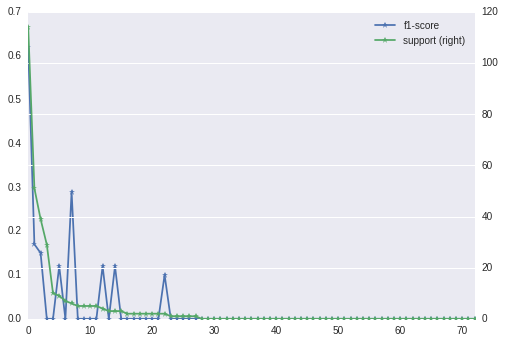

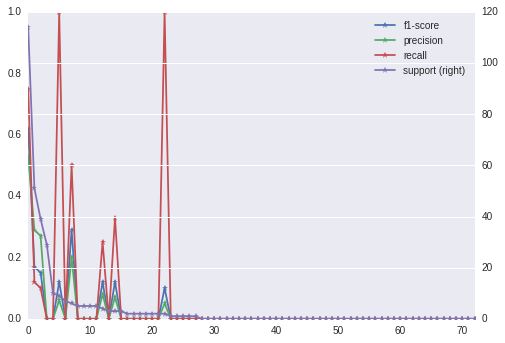

In [24]:
y_pred = y_pred_prob > 0.1
print(classification_report(y_true, y_pred, target_names=clf.get_tag_names()))
print('hamming loss:', hamming_loss(y_true, y_pred))
print('LRAP:', label_ranking_average_precision_score(y_true, y_pred))
clf_rep_df = get_classification_report_df(y_true, y_pred, target_names=clf.get_tag_names())
clf_rep_df.sort_values(by='support', ascending=False, inplace=True)
clf_rep_df.index = range(len(clf_rep_df))
clf_rep_df.plot(y=['f1-score', 'support'], secondary_y=['support'], style='*-')
plt.show()
clf_rep_df.plot(y=['f1-score', 'precision', 'recall', 'support'], secondary_y=['support'], style='*-')
plt.show()